<a href="https://colab.research.google.com/github/somilasthana/MachineLearningSkills/blob/master/Analytics_Customer_Life_Time_Value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!wget https://github.com/1dhiman/100days-ml/blob/master/data/Online%20Retail.xlsx?raw=true

--2019-06-21 01:24:00--  https://github.com/1dhiman/100days-ml/blob/master/data/Online%20Retail.xlsx?raw=true
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/1dhiman/100days-ml/raw/master/data/Online%20Retail.xlsx [following]
--2019-06-21 01:24:00--  https://github.com/1dhiman/100days-ml/raw/master/data/Online%20Retail.xlsx
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/1dhiman/100days-ml/master/data/Online%20Retail.xlsx [following]
--2019-06-21 01:24:00--  https://raw.githubusercontent.com/1dhiman/100days-ml/master/data/Online%20Retail.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:4

In [26]:
!pip install lifetimes

     |████████████████████████████████| 583kB 2.8MB/s 


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import datetime as dt
import scipy

from lifetimes.plotting import *
from lifetimes.utils import *


In [35]:
df = pd.read_excel("/content/Online Retail.xlsx?raw=true")

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [0]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date
df = df[pd.notnull(df["CustomerID"])]
df = df[df["Quantity"] > 0]

df["Sales"] = df["Quantity"] * df["UnitPrice"]

In [0]:
df["CustomerID"] = df["CustomerID"].astype(int)

In [0]:
cols_of_interest = ['CustomerID', 'InvoiceDate', 'Sales']
df_clv = df[cols_of_interest]

In [39]:
df_clv.head()

,CustomerID,InvoiceDate,Sales
0,17850,2010-12-01,15.30
1,17850,2010-12-01,20.34
2,17850,2010-12-01,22.00
3,17850,2010-12-01,20.34
4,17850,2010-12-01,20.34


In [40]:
df_clv.InvoiceDate.min(), df_clv.InvoiceDate.max()

(datetime.date(2010, 12, 1), datetime.date(2011, 12, 9))

In [41]:
"""
frequency: Number of repeat orders
recency: duration between customers first order and last order ( if one order then value is 0)
T: Age of customer duration between its first purchase and end-date
"""
data = summary_data_from_transaction_data(df_clv, 'CustomerID', 'InvoiceDate', monetary_value_col='Sales', observation_period_end='2011-12-9')
data.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346,0.0,0.0,325.0,0.000000
12347,6.0,365.0,367.0,599.701667
12348,3.0,283.0,358.0,301.480000
12349,0.0,0.0,18.0,0.000000
12350,0.0,0.0,310.0,0.000000


In [42]:
data[["frequency", "recency", "T", "monetary_value"]].describe()

,frequency,recency,T,monetary_value
count,4339.000000,4339.000000,4339.000000,4339.000000
mean,2.864024,130.741415,222.782899,306.944168
std,5.952745,132.210176,117.883623,2612.453380
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,112.000000,0.000000
50%,1.000000,93.000000,248.000000,176.940000
75%,3.000000,252.000000,326.000000,360.161667
max,131.000000,373.000000,373.000000,168469.600000


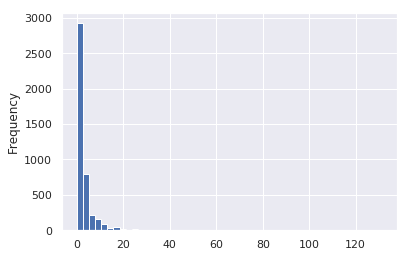

In [43]:
data['frequency'].plot(kind='hist', bins=50)

Frequency/Recency Analysis Using the BG/NBD Model

In [44]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>


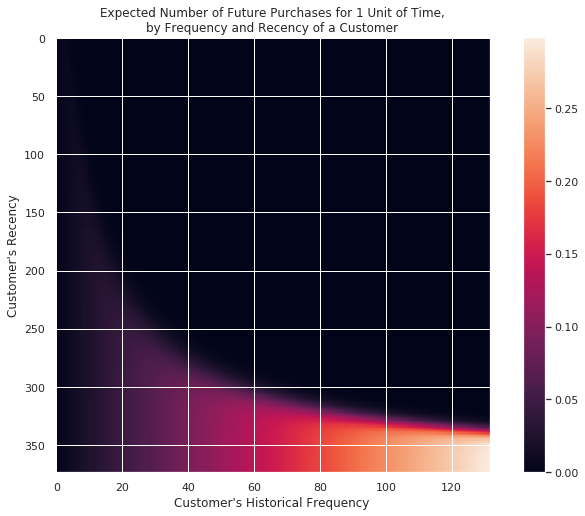

In [45]:
from lifetimes.plotting import plot_frequency_recency_matrix
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

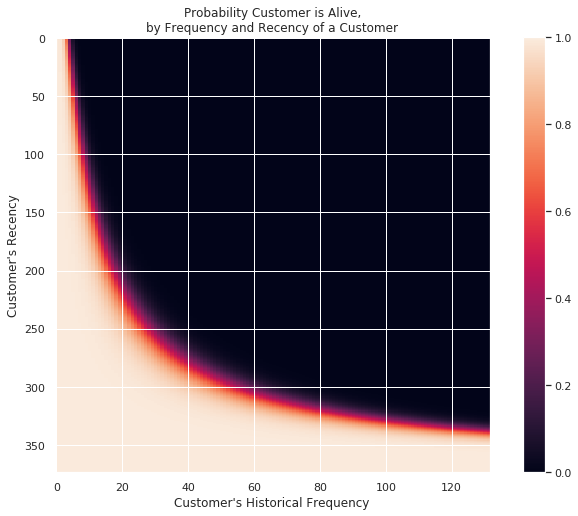

In [46]:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

In [47]:
"""
Models expose a method that will predict a customer’s expected purchases in the 
next period using their history.

The BG/NBD model believes these individuals will be making more purchases 
within the near future as they are our current best customers.
"""

t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)


,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
14606,88.0,372.0,373.0,135.890114,0.201005
15311,89.0,373.0,373.0,677.729438,0.203269
17841,111.0,372.0,373.0,364.452162,0.253053
12748,113.0,373.0,373.0,298.360885,0.257581
14911,131.0,372.0,373.0,1093.661679,0.298312


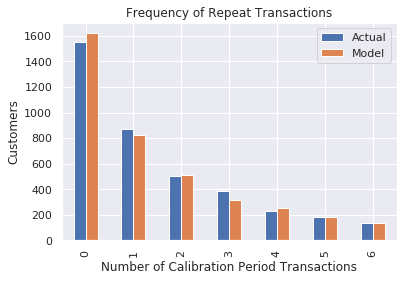

In [48]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [49]:
"""
We now partition the dataset into a calibration period dataset and a holdout dataset. 
This is important as we want to test how our model performs on data not yet seen 
"""
from lifetimes.utils import calibration_and_holdout_data
summary_cal_holdout = calibration_and_holdout_data(df, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-06-08',
                                        observation_period_end='2011-12-9' )   

summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346,0.0,0.0,141.0,0.0,184
12347,2.0,121.0,183.0,4.0,184
12348,2.0,110.0,174.0,1.0,184
12350,0.0,0.0,126.0,0.0,184
12352,3.0,34.0,112.0,3.0,184


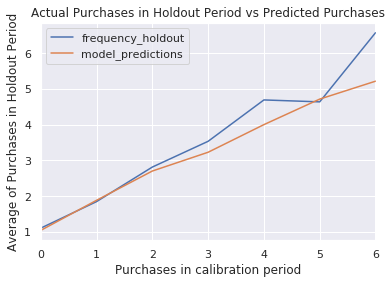

In [50]:
"""
The plot groups all customers in the calibration period by their number of repeat 
purchases (x-axis) and then averages over their repeat purchases in the holdout 
period (y-axis). 
"""
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In [51]:
t = 10
individual = data.loc[12347]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.15727742663038222

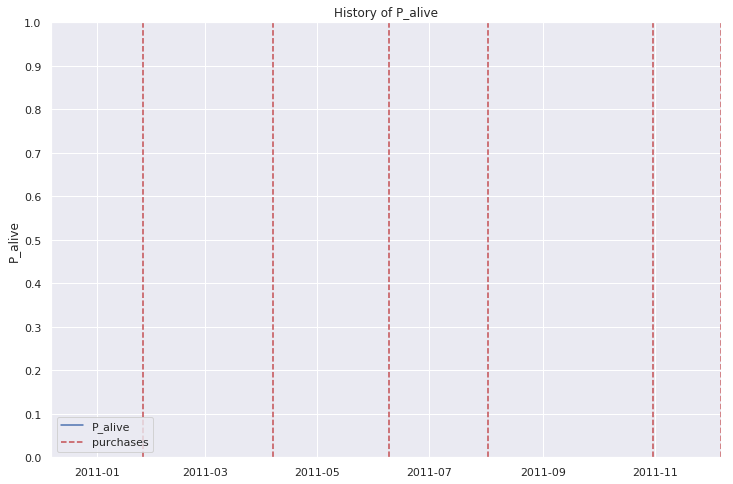

In [52]:
# History
from lifetimes.plotting import plot_history_alive
fig = plt.figure(figsize=(12,8))
id = 12347
days_since_birth = 365
sp_trans = df.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate');

In [53]:
data.head()

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
12346,0.0,0.0,325.0,0.000000,0.002098
12347,6.0,365.0,367.0,599.701667,0.015656
12348,3.0,283.0,358.0,301.480000,0.008956
12349,0.0,0.0,18.0,0.000000,0.009511
12350,0.0,0.0,310.0,0.000000,0.002181


In [55]:
#Estimating customer lifetime value using gamma-gamma model of monetary value
# works only for monetary_value > 0.0 or fails

from lifetimes import GammaGammaFitter
returning_customers_summary = data[data['frequency']>0]

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>


In [56]:
ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).head(10)

CustomerID
12346    416.917667
12347    569.988807
12348    333.762672
12349    416.917667
12350    416.917667
12352    376.166864
12353    416.917667
12354    416.917667
12355    416.917667
12356    324.008941
dtype: float64

In [57]:
# Calculate CLV

ggf.customer_lifetime_value(
    bgf,
    data['frequency'],
    data['recency'],
    data['T'],
    data['monetary_value'],
    time=12,
    discount_rate=0.01).head()

CustomerID
12346     270.691520
12347    3026.930610
12348    1005.058369
12349    1312.340240
12350     281.612972
Name: clv, dtype: float64

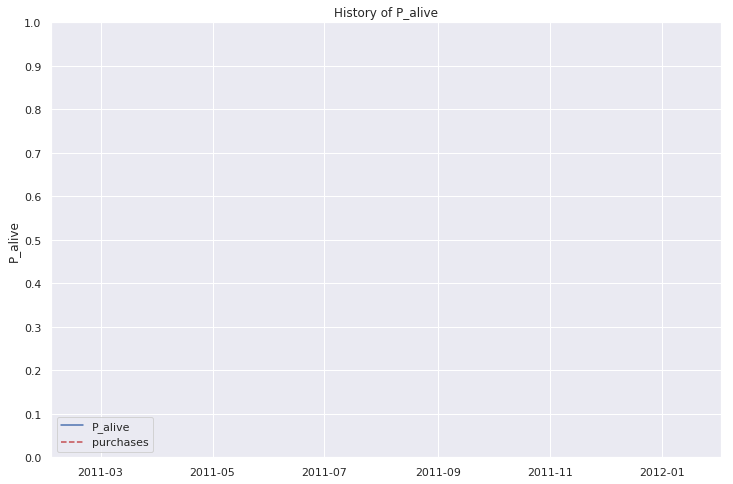

In [58]:
# 12350 has less CLV lets see why
from lifetimes.plotting import plot_history_alive
fig = plt.figure(figsize=(12,8))
id = 12350
days_since_birth = 365
sp_trans = df.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate');

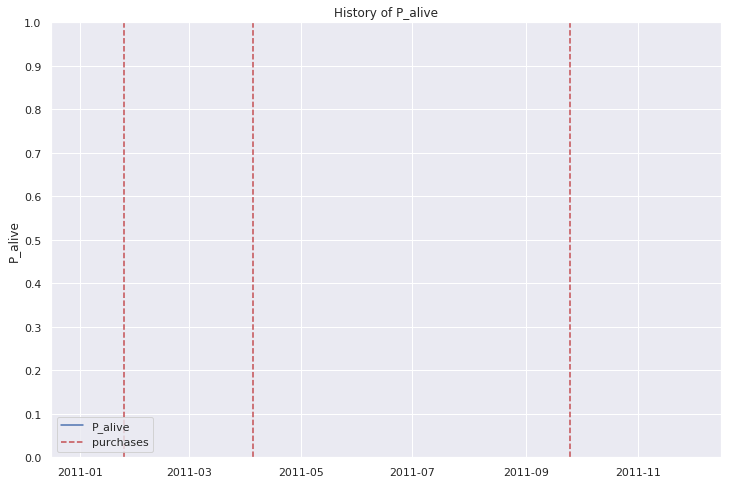

In [59]:
# 12348 has less CLV lets see why
from lifetimes.plotting import plot_history_alive
fig = plt.figure(figsize=(12,8))
id = 12348
days_since_birth = 365
sp_trans = df.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate');